In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

modelnn = NeuralNetwork().to(device)
print(modelnn)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14 -> 7x7
        )
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv_stack(x)
        return self.fc_stack(x)

modelcnn = CNN().to(device)
print(modelcnn)

Using cpu device
CNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer_nn = torch.optim.SGD(modelnn.parameters(), lr=1e-3)
optimizer_cnn = torch.optim.Adam(modelcnn.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / size
    return avg_loss, accuracy

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy

In [11]:
epochs = 5
train_losses_nn, test_losses_nn = [], []
train_accs_nn, test_accs_nn = [], []
train_losses_cnn, test_losses_cnn = [], []
train_accs_cnn, test_accs_cnn = [], []

for t in range(epochs):
    print(f"\nEpoch nn {t+1}\n-------------------------------")
    tr_loss_nn, tr_acc_nn = train(train_dataloader, modelnn, loss_fn, optimizer_nn)
    te_loss_nn, te_acc_nn = test(test_dataloader, modelnn, loss_fn)
    train_losses_nn.append(tr_loss_nn); test_losses_nn.append(te_loss_nn)
    train_accs_nn.append(tr_acc_nn); test_accs_nn.append(te_acc_nn)
    print(f"Epoch {t+1} summary nn: train_loss_nn={tr_loss_nn:.4f}, train_acc_nn={tr_acc_nn:.3f}, test_loss_nn={te_loss_nn:.4f}, test_acc_nn={te_acc_nn:.3f}")
    print(f"\nEpoch cnn {t+1}\n-------------------------------")
    tr_loss_cnn, tr_acc_cnn = train(train_dataloader, modelcnn, loss_fn, optimizer_cnn)
    te_loss_cnn, te_acc_cnn = test(test_dataloader, modelcnn, loss_fn)
    train_losses_cnn.append(tr_loss_cnn); test_losses_cnn.append(te_loss_cnn)
    train_accs_cnn.append(tr_acc_cnn); test_accs_cnn.append(te_acc_cnn)
    print(f"Epoch {t+1} summary cnn: train_loss_cnn={tr_loss_cnn:.4f}, train_acc_cnn={tr_acc_cnn:.3f}, test_loss_cnn={te_loss_cnn:.4f}, test_acc_cnn={te_acc_cnn:.3f}")

print("Done!")


Epoch nn 1
-------------------------------
loss: 2.318990  [   64/60000]
loss: 2.302607  [ 6464/60000]
loss: 2.283725  [12864/60000]
loss: 2.273811  [19264/60000]
loss: 2.250204  [25664/60000]
loss: 2.239510  [32064/60000]
loss: 2.237063  [38464/60000]
loss: 2.203424  [44864/60000]
loss: 2.213750  [51264/60000]
loss: 2.178271  [57664/60000]
Test Error: 
 Accuracy: 44.2%, Avg loss: 2.173897 

Epoch 1 summary nn: train_loss_nn=2.2446, train_acc_nn=0.331, test_loss_nn=2.1739, test_acc_nn=0.442

Epoch cnn 1
-------------------------------
loss: 2.295679  [   64/60000]
loss: 0.706992  [ 6464/60000]
loss: 0.341575  [12864/60000]
loss: 0.518156  [19264/60000]
loss: 0.499137  [25664/60000]
loss: 0.491703  [32064/60000]
loss: 0.330771  [38464/60000]
loss: 0.516426  [44864/60000]
loss: 0.435031  [51264/60000]
loss: 0.435819  [57664/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.367724 

Epoch 1 summary cnn: train_loss_cnn=0.4728, train_acc_cnn=0.831, test_loss_cnn=0.3677, test_acc_cnn=0.865


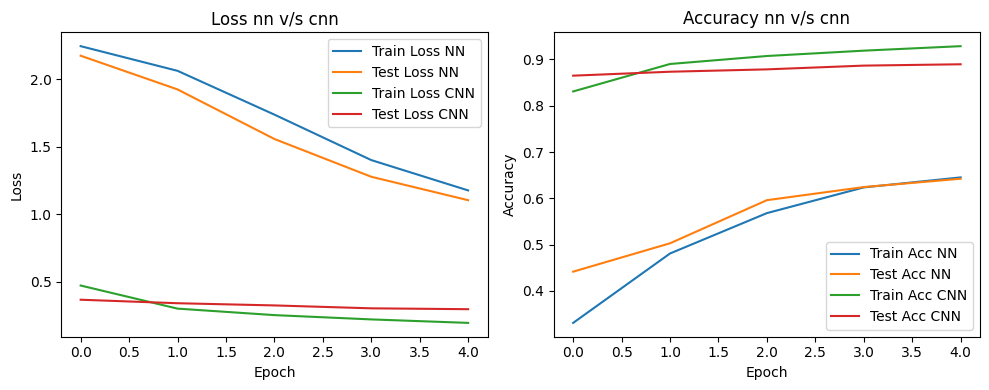

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses_nn, label="Train Loss NN")
plt.plot(test_losses_nn, label="Test Loss NN")
plt.plot(train_losses_cnn, label="Train Loss CNN")
plt.plot(test_losses_cnn, label="Test Loss CNN")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss nn v/s cnn")

plt.subplot(1,2,2)
plt.plot(train_accs_nn, label="Train Acc NN")
plt.plot(test_accs_nn, label="Test Acc NN")
plt.plot(train_accs_cnn, label="Train Acc CNN")
plt.plot(test_accs_cnn, label="Test Acc CNN")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy nn v/s cnn")

plt.tight_layout()
plt.show()

In [13]:
torch.save(modelnn.state_dict(), "modelnn.pth")
print("Saved PyTorch Model State to modelnn.pth")
torch.save(modelcnn.state_dict(), "modelcnn.pth")
print("Saved PyTorch Model State to modelcnn.pth")

Saved PyTorch Model State to modelnn.pth
Saved PyTorch Model State to modelcnn.pth


In [14]:
modelnn = NeuralNetwork().to(device)
modelnn.load_state_dict(torch.load("modelnn.pth", weights_only=True))

<All keys matched successfully>

In [15]:
modelcnn = CNN().to(device)
modelcnn.load_state_dict(torch.load("modelcnn.pth", weights_only=True))

<All keys matched successfully>

In [17]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

modelnn.eval()
modelcnn.eval()
x, y = test_data[0][0], test_data[0][1]
x_input = x.unsqueeze(0).to(device)
actual = classes[y]

with torch.no_grad():
    x = x.to(device)
    pred_nn = modelnn(x)
    pred_cnn = modelcnn(x_input)
    predicted_nn = classes[pred_nn[0].argmax(0)]
    predicted_cnn = classes[pred_cnn[0].argmax(0)]
    print(f'Predicted NN: "{predicted_nn}", Actual: "{actual}"')
    print(f'Predicted CNN: "{predicted_cnn}", Actual: "{actual}"')

Predicted NN: "Ankle boot", Actual: "Ankle boot"
Predicted CNN: "Ankle boot", Actual: "Ankle boot"


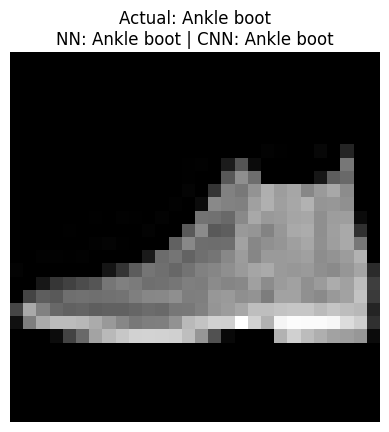

In [20]:
plt.imshow(x.squeeze(), cmap="gray")
plt.title(f'Actual: {actual}\nNN: {predicted_nn} | CNN: {predicted_cnn}')
plt.axis("off")
plt.show()

In [21]:
dummy_input = torch.randn(1, 1, 28, 28).to(device)

torch.onnx.export(
    modelnn, dummy_input, "fashion_mnist.onnx",
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print("Modelo exportado a fashion_mnist.onnx")

torch.onnx.export(
    modelcnn, dummy_input, "fashion_mnist_cnn.onnx",
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
print("Modelo CNN exportado a fashion_mnist_cnn.onnx")

/tmp/ipykernel_5100/1404124820.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Modelo exportado a fashion_mnist.onnx


/tmp/ipykernel_5100/1404124820.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Modelo CNN exportado a fashion_mnist_cnn.onnx
